In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# 创建SparkSession
spark = SparkSession.builder.appName("MovieRecommend")\
    .config("spark.executor.memory", "8G")\
    .config("spark.executor.cores", "4")\
    .config("spark.executor.instances", "4")\
    .config("spark.driver.memory", "8G")\
    .getOrCreate()


# 加载数据
ratings_df = spark.read.csv("dataset/ratings.csv", inferSchema=True, header=True)

# Read additional data
tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)
genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)

In [14]:
# Join DataFrames
# complete_data = movies_df.join(tags_df, "movieId") \
#                         .join(genome_scores_df, "movieId") \
#                         .join(genome_tags_df, "tagId") \
#                         .join(ratings_df, ["userId", "movieId"])

# genome_data=genome_scores_df.join(genome_tags_df,"tagId")

# complete_data=ratings_df.join(movies_df,"movieId")\
# .join(tags_df,"movieId")\
# .join(genome_data,["movieId","tag"])

# complete_data.printSchema()
# # complete_data.show(5)
# complete_data.count()

In [15]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def add_sample_label(ratings_df):
    # Show the first 5 rows and print the schema before modification
    ratings_df.show(5, truncate=False)
    ratings_df.printSchema()

    # Add a new column 'label' based on the condition
    ratings_df = ratings_df.withColumn('label', F.when(F.col('rating') >= 3.5, 2).otherwise(3))

    return ratings_df


In [16]:
import re
# Extract movie year
def parse_year(title):
    pattern = r"\((\d{4})\)"  # 正则表达式模式，匹配括号内的四位数字
    match = re.search(pattern, title)
    if match:
        year_str = match.group(1)
        return int(year_str)
    else:
        return 1900

In [17]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import os
import pickle
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline

# # spark = SparkSession.builder.appName("PrepareData").getOrCreate()
# # 创建SparkSession
# spark = SparkSession.builder.appName("MovieRecommend")\
#     .config("spark.executor.memory", "8G")\
#     .config("spark.executor.cores", "4")\
#     .config("spark.executor.instances", "4")\
#     .config("spark.driver.memory", "8G")\
#     .getOrCreate()


# Read movie data
data_path = "dataset/"
df_movie = spark.read.csv(
    "dataset/movies.csv", header=True,inferSchema=True)

# Extract movie year
parse_year_udf = udf(parse_year, IntegerType())
df_movie = df_movie.withColumn("movie_year", parse_year_udf(df_movie['title']))
df_movie=df_movie.drop('title')

# # Join genome data to df
# df = df.join(genome_scores_df, "movieId")
# df = df.join(genome_tags_df, "tagId")

# One-hot encoding genres
genres = df_movie.select("genres").distinct().rdd.flatMap(lambda x: x).collect()
genres_unique = list(set([i for sublist in genres for i in sublist.split("|")]))

for genres_name in genres_unique:
    col = "genres_" + genres_name
    df_movie = df_movie.withColumn(col, 
                                   (df_movie.genres.contains(genres_name)).cast(IntegerType()))

df_movie = df_movie.drop('genres')
genres_col_names = ["genres_" + x for x in genres_unique]

# Read rating data

df_rating = spark.read.csv(
    "dataset/ratings.csv",
    header=True,
    inferSchema=True
)

df_rating = add_sample_label(df_rating)
df_rating = df_rating.withColumn('timestamp', (df_rating['timestamp'] / (365 * 24 * 3600)).cast(IntegerType()))

# Data merge
df = df_rating.join(df_movie, 'movieId')


# df_X = df.select(["userId", "movieId"] + genres_col_names + ["timestamp"])
# df_y = df.select(["rating"])
# print("Data read completed")

df.printSchema()
df.show(20)
# df_X.show(10)
# df_y.show(10)


+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |296    |5.0   |1147880044|
|1     |306    |3.5   |1147868817|
|1     |307    |5.0   |1147868828|
|1     |665    |5.0   |1147878820|
|1     |899    |3.5   |1147868510|
+------+-------+------+----------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- label: integer (nullable = false)
 |-- movie_year: integer (nullable = true)
 |-- genres_Action: integer (nullable = true)
 |-- genres_Horror: integer (nullable = true)
 |-- genres_Comedy: integer (nullable = true)
 |-- genres_Animation: integer (nullable = true)
 |-- genres_Musical: integer (nullable = true)
 |-- genres_Fil

In [18]:
from pyspark.ml.feature import VectorAssembler

# 使用 VectorAssembler 进行特征组合
assembler = VectorAssembler(
    inputCols=["userId", "movieId", "timestamp","movie_year","label"] + genres_col_names ,
    outputCol="features"
)

# 对数据框进行转换
df = assembler.transform(df)

# 打印数据读取完成的消息
print("Data read completed")


Data read completed


In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

(training_data, test_data) = df.randomSplit([0.7, 0.3],seed=123)

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="rating",
    numTrees=10,
    maxDepth=7,
    maxBins=32,
    minInstancesPerNode=1
)

# 训练模型
model_rf = rf.fit(training_data)

# Predicting on test data
predictions_rf = model_rf.transform(test_data)



# Define multiple evaluators
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

rmse = rmse_evaluator.evaluate(predictions_rf)
mae = mae_evaluator.evaluate(predictions_rf)
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

23/11/29 09:43:03 WARN MemoryStore: Not enough space to cache rdd_294_5 in memory! (computed 104.0 MiB so far)
23/11/29 09:43:03 WARN BlockManager: Persisting block rdd_294_5 to disk instead.
23/11/29 09:43:03 WARN MemoryStore: Not enough space to cache rdd_294_4 in memory! (computed 104.0 MiB so far)
23/11/29 09:43:03 WARN BlockManager: Persisting block rdd_294_4 to disk instead.
23/11/29 09:43:04 WARN MemoryStore: Not enough space to cache rdd_294_1 in memory! (computed 104.0 MiB so far)
23/11/29 09:43:04 WARN BlockManager: Persisting block rdd_294_1 to disk instead.
23/11/29 09:43:04 WARN MemoryStore: Not enough space to cache rdd_294_8 in memory! (computed 104.0 MiB so far)
23/11/29 09:43:04 WARN BlockManager: Persisting block rdd_294_8 to disk instead.
23/11/29 09:43:04 WARN MemoryStore: Not enough space to cache rdd_294_10 in memory! (computed 104.0 MiB so far)
23/11/29 09:43:04 WARN BlockManager: Persisting block rdd_294_10 to disk instead.
23/11/29 09:43:04 WARN MemoryStore: No

Root Mean Square Error (RMSE): 0.6054813981609843
Mean Absolute Error (MAE): 0.5013850522995075


DataFrame[title: string, prediction: double]


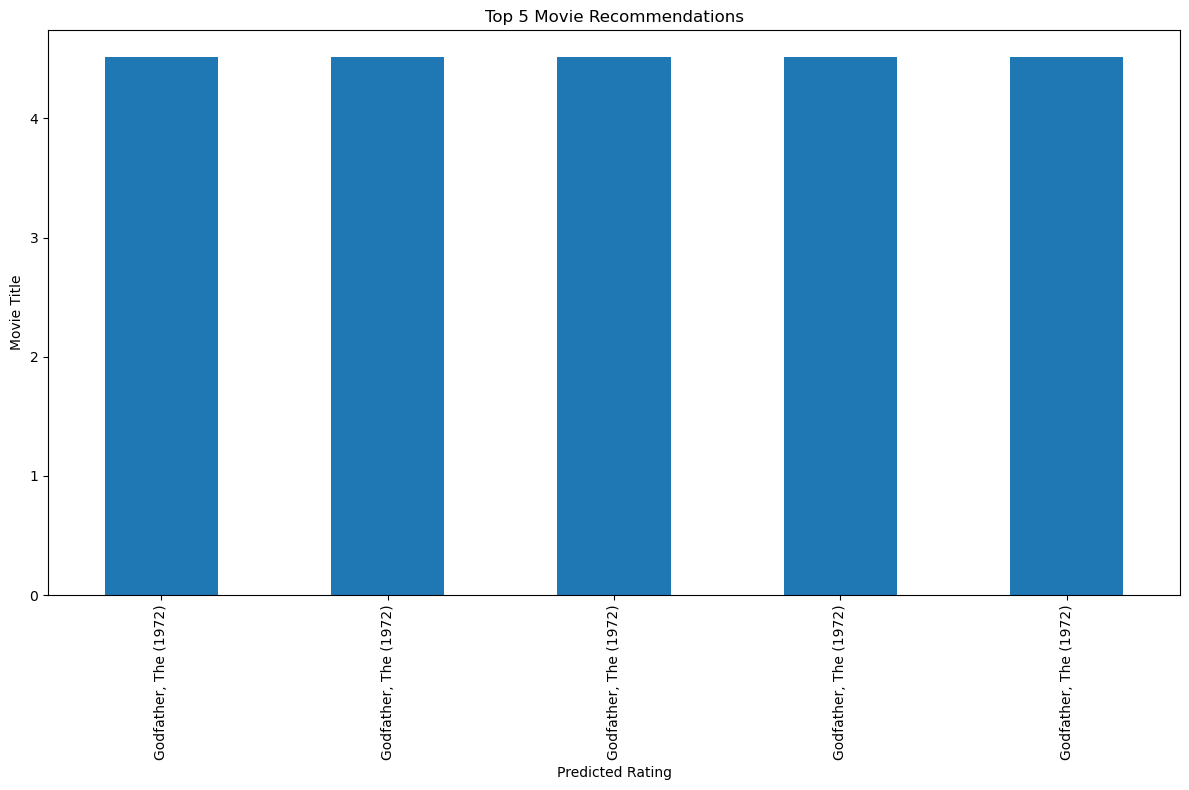

In [20]:
import matplotlib.pyplot as plt

 # Get top5 movie recommendations
top_predictions = predictions_rf .orderBy('prediction', ascending=False).limit(5)

    # Join with the movies dataframe to get movie titles
movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)  # Load movies data
top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title', 'prediction')
print(top_movies_with_titles)

    # Convert to pandas dataframe for visualization
top_movies_pd = top_movies_with_titles.toPandas()
top_movies_pd.set_index('title', inplace=True)

    # Plot
plt.figure(figsize=(12, 8))
top_movies_pd['prediction'].plot(kind='bar')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Title')
plt.title('Top 5 Movie Recommendations')
plt.tight_layout()
plt.show()
plt.close()

In [21]:
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.regression import RandomForestRegressor
# from pyspark.sql.functions import col, lit, explode
# import matplotlib.pyplot as plt




# # Create a DataFrame with all unique user IDs
# all_users = df.select("userId").distinct()

# # Cross join with the features of all distinct movies
# all_users_recs = all_users.crossJoin(df.select("movieId", "timestamp","movie_year","label").distinct())

# # Vectorize features for the recommendation DataFrame
# all_users_recs = assembler.transform(all_users_recs)


# # Predict using the trained model
# all_users_predictions = model_rf.transform(all_users_recs)


#  # Get top5 movie recommendations
# top_predictions = all_users_predictions .orderBy('prediction', ascending=False).limit(5)

#     # Join with the movies dataframe to get movie titles
# movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)  # Load movies data
# top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title', 'prediction')
# print(top_movies_with_titles)

#     # Convert to pandas dataframe for visualization
# top_movies_pd = top_movies_with_titles.toPandas()
# top_movies_pd.set_index('title', inplace=True)

#     # Plot
# plt.figure(figsize=(12, 8))
# top_movies_pd['prediction'].plot(kind='bar')
# plt.xlabel('Predicted Rating')
# plt.ylabel('Movie Title')
# plt.title('Top 5 Movie Recommendations')
# plt.tight_layout()
# plt.show()
# plt.close()



In [22]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import RegressionEvaluator
# from datetime import datetime
# import pandas as pd

# # # Create a Spark session
# # spark = SparkSession.builder.appName("RandomForestRegressorExample").getOrCreate()


# # Select features and target column
# df = df.select("features", "rating")

# # Split the data into training and test sets
# (training_data, test_data) = df.randomSplit([0.7, 0.3], seed=123)

# # Create a RandomForestRegressor
# rf = RandomForestRegressor(featuresCol="features", labelCol="rating")

# # Define the parameter grid to search over
# param_grid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [10, 20, 30]) \
#     .addGrid(rf.maxDepth, [5, 10, 15]) \
#     .addGrid(rf.maxBins, [16, 32, 64]) \
#     .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
#     .build()


# # Define multiple evaluators
# rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
# mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

# # Create the CrossValidator
# crossval = CrossValidator(estimator=rf,
#                           estimatorParamMaps=param_grid,
#                           evaluator=rmse_evaluator,
#                           numFolds=3)  # Number of folds for cross-validation

# # Record the start time
# start_time = datetime.now()

# # Run cross-validation, and choose the best set of parameters
# cv_model = crossval.fit(training_data)

# # Record the end time
# end_time = datetime.now()

# # Calculate the training time
# training_time = end_time - start_time
# print(f"Training Time: {training_time}")

# # Make predictions on test data
# predictions_rf_cv = cv_model.transform(test_data)

# # Evaluate the model
# rmse_cv = rmse_evaluator.evaluate(predictions_rf_cv)
# mae_cv = mae_evaluator.evaluate(predictions_rf_cv)
# print(f"Cross-validated Root Mean Square Error (RMSE): {rmse_cv}")
# print(f"Cross-validated Mean Absolute Error (MAE): {mae_cv}")

# # Print the best parameters found during cross-validation
# best_params = cv_model.bestModel.extractParamMap()
# print("Best Parameters:")
# for param, value in best_params.items():
#     print(f"{param.name}: {value}")

# # Create a pandas DataFrame with the results
# results_dict = {
#     "Training Time": [str(training_time)],
#     "RMSE": [rmse_cv],
#     "MAE": [mae_cv],
#     "Best Parameters": [best_params]
# }

# results_df = pd.DataFrame(results_dict)

# # Save the DataFrame to a CSV file
# csv_path = "/root/CineSpark-Insights/results/rf_model_performance.csv"
# results_df.to_csv(csv_path, index=False)

# print(f"Results saved to: {csv_path}")


In [23]:
# from pyspark.ml.feature import StringIndexer, VectorAssembler
# from pyspark.ml.regression import RandomForestRegressor
# from pyspark.ml.evaluation import RegressionEvaluator
# import time
# import pandas as pd



# # 选择特征和目标列
# df = df.select("features", "rating")

# # 划分数据集为训练集和测试集
# (training_data, test_data) = df.randomSplit([0.7, 0.3],seed=123)

# start_time = time.time()

# rf = RandomForestRegressor(
#     featuresCol="features",
#     labelCol="rating",
#     numTrees=10,
#     maxDepth=5,
#     maxBins=64,
#     minInstancesPerNode=1
# )

# # 训练模型
# model_rf = rf.fit(training_data)

# # Predicting on test data
# predictions_rf = model_rf.transform(test_data)



# # Define multiple evaluators
# rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
# mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

# rmse = rmse_evaluator.evaluate(predictions_rf)
# mae = mae_evaluator.evaluate(predictions_rf)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution Time: {execution_time} seconds")
# print(f"Root Mean Square Error (RMSE): {rmse}")
# print(f"Mean Absolute Error (MAE): {mae}")

# # 将结果保存到DataFrame
# results_dict = {
#     "NumTrees": [rf.getNumTrees()],
#     "MaxDepth": [rf.getMaxDepth()],
#     "MaxBins": [rf.getMaxBins()],
#     "MinInstancesPerNode": [rf.getMinInstancesPerNode()],
#     "RMSE": [rmse],
#     "MAE": [mae],
#     "ExecutionTime": [execution_time]
# }

# results_df = pd.DataFrame(results_dict)

# # 写入CSV文件
# results_df.to_csv('/root/CineSpark-Insights/results/rf_model_performance.csv', index=False)

In [24]:
# import pandas as pd
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.regression import RandomForestRegressor
# import time
# from itertools import product

# def train_and_evaluate_rf(numTrees, maxDepth, maxBins, minInstancesPerNode):
#     # ... (SparkSession initialization and data preprocessing steps)

#     # Split the dataset into training and test sets
#     (training_data, test_data) = df.randomSplit([0.7, 0.3], seed=123)
    
#     start_time = time.time()

#     rf = RandomForestRegressor(
#         featuresCol="features",
#         labelCol="rating",
#         numTrees=numTrees,
#         maxDepth=maxDepth,
#         maxBins=maxBins,
#         minInstancesPerNode=minInstancesPerNode
#     )

#     # Train the model
#     model_rf = rf.fit(training_data)

#     # Predicting on test data
#     predictions_rf = model_rf.transform(test_data)

#     # Define evaluators
#     rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
#     mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

#     # Evaluate model
#     rmse = rmse_evaluator.evaluate(predictions_rf)
#     mae = mae_evaluator.evaluate(predictions_rf)
    
#     # Record execution time
   
#     end_time = time.time()
#     execution_time = end_time - start_time

#     # ... (Code for calculating execution time and saving results)

#     # Return results
#     return {
#         "NumTrees": numTrees,
#         "MaxDepth": maxDepth,
#         "MaxBins": maxBins,
#         "MinInstancesPerNode": minInstancesPerNode,
#         "RMSE": rmse,
#         "MAE": mae,
#         "ExecutionTime": execution_time
#     }

# # Call the function with different parameter combinations
# num_trees = [10]
# max_depth = [5]
# max_bins = [32]
# min_instances_per_node = [1]

# param_combinations = list(product(num_trees, max_depth, max_bins, min_instances_per_node))


# for params in param_combinations:
#     result = train_and_evaluate_rf(*params)
#     results_df = pd.DataFrame(result, index=[0])

#     # Write to CSV file (append mode)
# results_df.to_csv('/root/CineSpark-Insights/results/rf_model_performance.csv', mode='a', index=False, header=False)
